# Top 50 with 4 features

In this notebook I want to demonstrate that it is enough to correctly use the simplest features and Logistic Regression to get high score. 

In [1]:
# I used scikit-learn v. 1.0.2 on my computer. So I do the same here
!pip install scikit-learn==1.0.2
!pip install pandas==1.5.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 41.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
bigframes 0.22.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.8.2 which is incomp

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import eli5
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from IPython.display import display_html
from sklearn.metrics import confusion_matrix

In [4]:
print(pd.__version__)

1.5.3


## Basic functions and TF-IDF

First I'll use basic functions of creating a sparse matrix, TF-IDF vectorization and result loading from Yorko's notebook

WARNING! I'm not using original dataset of this competition because it has parsing erros. Instead I use open-ml-course-linear-models-spring22 dataset.

In [5]:
PATH_TO_DATA = r'/kaggle/input/open-ml-course-linear-models-spring22/'
SEED = 241

### Sparse matrix

In [6]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

### TF-IDF

In [7]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 3),
                       'max_features': 30000, 
                       'tokenizer': lambda s: s.split()}
)

CPU times: user 26.7 s, sys: 809 ms, total: 27.5 s
Wall time: 28.1 s


### Sites data

In [8]:
sites_dict = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_dic.pkl'))
sites_dict_inv = {v: k for k, v in sites_dict.items()}

sites_train = ['site%s' % i for i in range(1, 11)] + ['target']
sites_test = ['site%s' % i for i in range(1, 11)]
train_sites = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'),
                       index_col='session_id', parse_dates=['time%s' % i for i in range(1, 11)])
test_sites = pd.read_csv(os.path.join(PATH_TO_DATA, 'test.csv'),
                       index_col='session_id', parse_dates=['time%s' % i for i in range(1, 11)])

train_sites = train_sites.sort_values(by='time1')
train_sites = train_sites[sites_train].fillna(0).astype('int')
test_sites = test_sites[sites_test].fillna(0).astype('int')

### Basic params

In [9]:
features_name = []
corr_df = []

In [10]:
time_split = TimeSeriesSplit(n_splits=10)

### Function for writing predictions to a file

In [11]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [12]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
        
    proba = model.predict_proba(X_train)
    predicted = model.predict(X_train)
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    table_confusion = confusion_matrix(y_train, predicted)
    print(table_confusion)
    
    return (proba, y_train, predicted, table_confusion, cv_scores)

# Time Features

You may have already noticed that Alice's and the intruder's Internet access times are significantly different. This is clearly visible on the bar chart with ten-minute segments.

In [13]:
session_start_hour = train_times['time1'].apply(lambda ts: 100 * ts.hour + int(ts.minute / 10)).values

Text(0.5, 0, 'Session start hour')

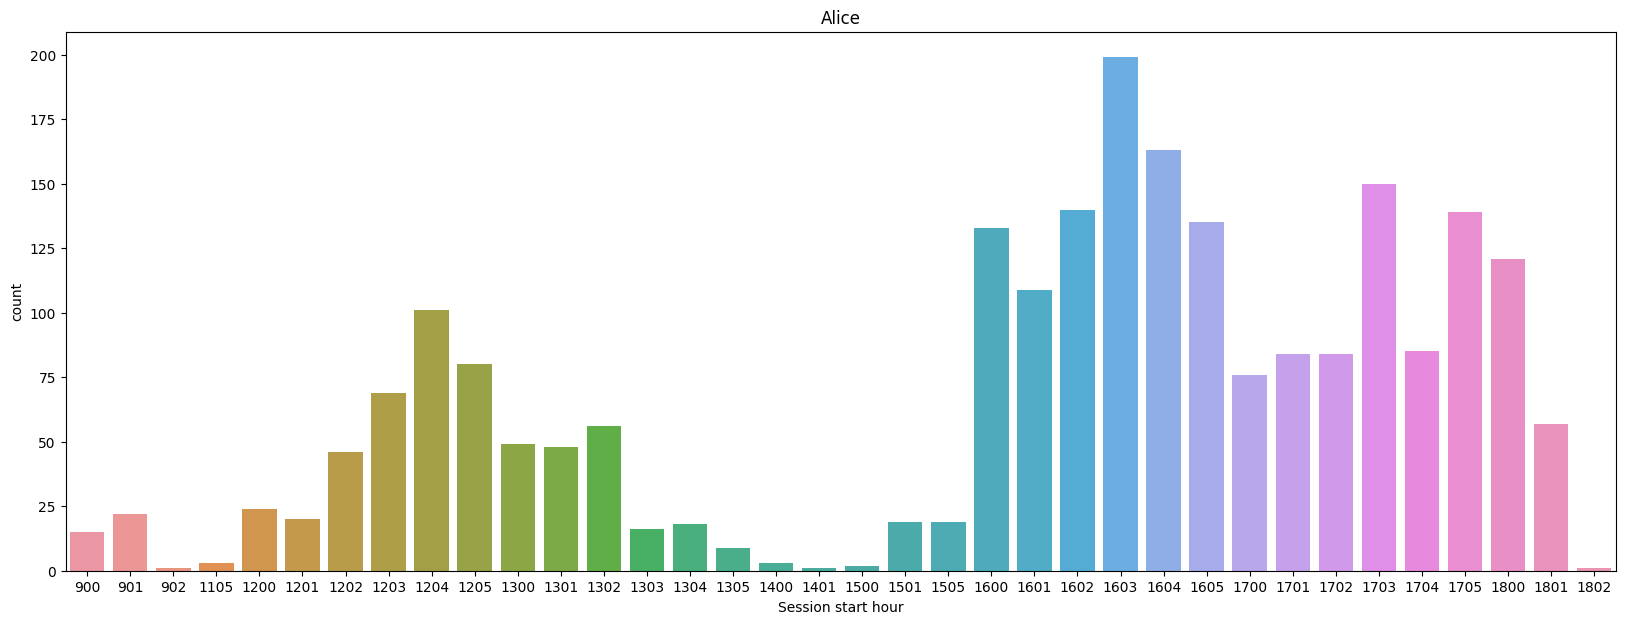

In [14]:
plt.subplots(1,  figsize = (20, 7)) 

sns.countplot(pd.DataFrame(session_start_hour[y_train == 1], columns=['time1']), x='time1')
plt.title("Alice")
plt.xlabel('Session start hour')

However, the marking on ten-minute data is not accurate enough, as well as the marking on half-hour and hour segments. It is best to select periods accurate to the minute, based on the periods of activity of Alice and the intruder.

In [15]:
def add_time_features(times, X_sparse, add_feat = True):
    hour = times['time1'].apply(lambda t: 100 * t.hour + t.minute) / 1000
    morning_1 = (((hour >= 0.901) & (hour <= 0.904) | (hour >= 0.922) & (hour <= 1.209)).astype('int') * hour).values.reshape(-1, 1)
    morning_2 = (((hour >= 0.905) & (hour <= 0.921)).astype('int') * hour).values.reshape(-1, 1)
    day_1 = (((hour >= 1.210) & (hour <= 1.239)).astype('int') * hour).values.reshape(-1, 1)
    day_2 = (((hour >= 1.240) & (hour <= 1.335)).astype('int') * hour).values.reshape(-1, 1)
    day_3 = (((hour >= 1.336) & (hour <= 1.358)).astype('int') * hour).values.reshape(-1, 1)
    day_4 = (((hour >= 1.359) & (hour <= 1.517)).astype('int') * hour).values.reshape(-1, 1)
    day_5 = (((hour >= 1.518) & (hour <= 1.553)).astype('int') * hour).values.reshape(-1, 1)
    evening_1 = (((hour >= 1.554) & (hour <= 1.629) | (hour >= 1.705) & (hour <= 1.755)) * hour).values.reshape(-1, 1)
    evening_2 = ((hour >= 1.653) & (hour <= 1.704)).values.reshape(-1, 1)
    evening_3 = (((hour >= 1.756) & (hour <= 1.828) | (hour >= 1.626) & (hour <= 1.656)) * hour).values.reshape(-1, 1)
    night = (((hour >= 1.829) & (hour <= 2.359) | (hour >= 0) & (hour <= 0.900)) * hour).values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning_1, morning_2, day_1, day_2, day_3, day_4, day_5, evening_1, evening_2, evening_3,night] # 
    feature_names = ['morning_1', 'morning_2', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5',  'evening_1', 'evening_2','evening_3', 'night'] #
    
    if add_feat:
        for i,j in zip(objects_to_hstack[1:], feature_names):
            feat = pd.DataFrame(pd.DataFrame(i, columns = [j]))
            corr_df.append(feat)
                            
    X = hstack(objects_to_hstack)
    return X, feature_names

In [16]:
X_train_final, new_feat_names = add_time_features(train_times, X_train_sites)
X_test_final, _ = add_time_features(test_times, X_test_sites, add_feat = False)

In [17]:
features_name += new_feat_names

# Day of week feature

Another obvious sign is the days of the week. But here you shouldn’t take all the days and leave them without transformation too. Sometimes it is useful to combine similar days into one feature.

In [18]:
dow = train_times['time1'].apply(lambda x: x.weekday())

Text(0.5, 0, 'Session start hour')

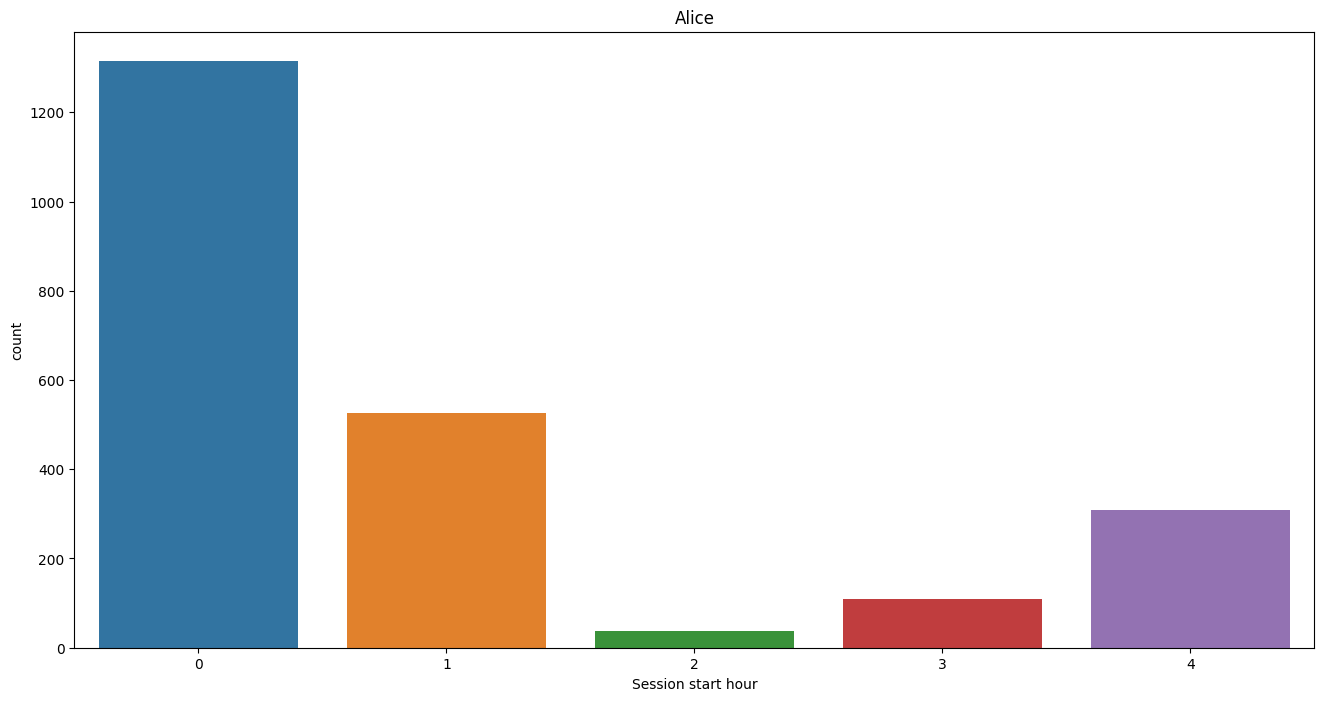

In [19]:
plt.subplots(1, figsize = (16, 8)) 

sns.countplot(pd.DataFrame(dow[y_train == 1]), x='time1')
plt.title("Alice")
plt.xlabel('Session start hour')

In [20]:
def add_day_month(times, X_sparse, add_feat = True):
    
    day_of_week = times['time1'].apply(lambda t: t.weekday())
    day_of_week_df = pd.get_dummies(day_of_week)
    day_of_week_df['5_6'] = day_of_week_df[5] + day_of_week_df[6]
    day_of_week_df['2_3'] = day_of_week_df[2] + day_of_week_df[3]
    
    for d in (2,3,5,6):
        del day_of_week_df[d]
    
    day_of_week_df = day_of_week_df.rename({i: 'weekday_' + str(i) for i in day_of_week_df.columns}, axis = 1)
    
    objects_to_hstack = [X_sparse, day_of_week_df]
    feature_names = ['weekday_' + str(i) for i in day_of_week_df.columns]
    if add_feat:
        corr_df.append(day_of_week_df.reset_index(drop=True))
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [21]:
X_train_final, more_feat_names = add_day_month(train_times, X_train_final)
X_test_final, _ = add_day_month(test_times, X_test_final, add_feat = False)

In [22]:
features_name += more_feat_names

# Day of month feature

The last feature is not so obvious. It's the day of the month. This is quite strange, since the days Alice visits sites may differ between training and test data. However, this feature still leads to a significant improvement in results. As before, you shouldn’t just take and use 31 features of the days of the month. It would be more correct to combine them into groups based on the activity of Alice and the intruder.

In [23]:
dom = train_times['time1'].apply(lambda ts: ts.day)

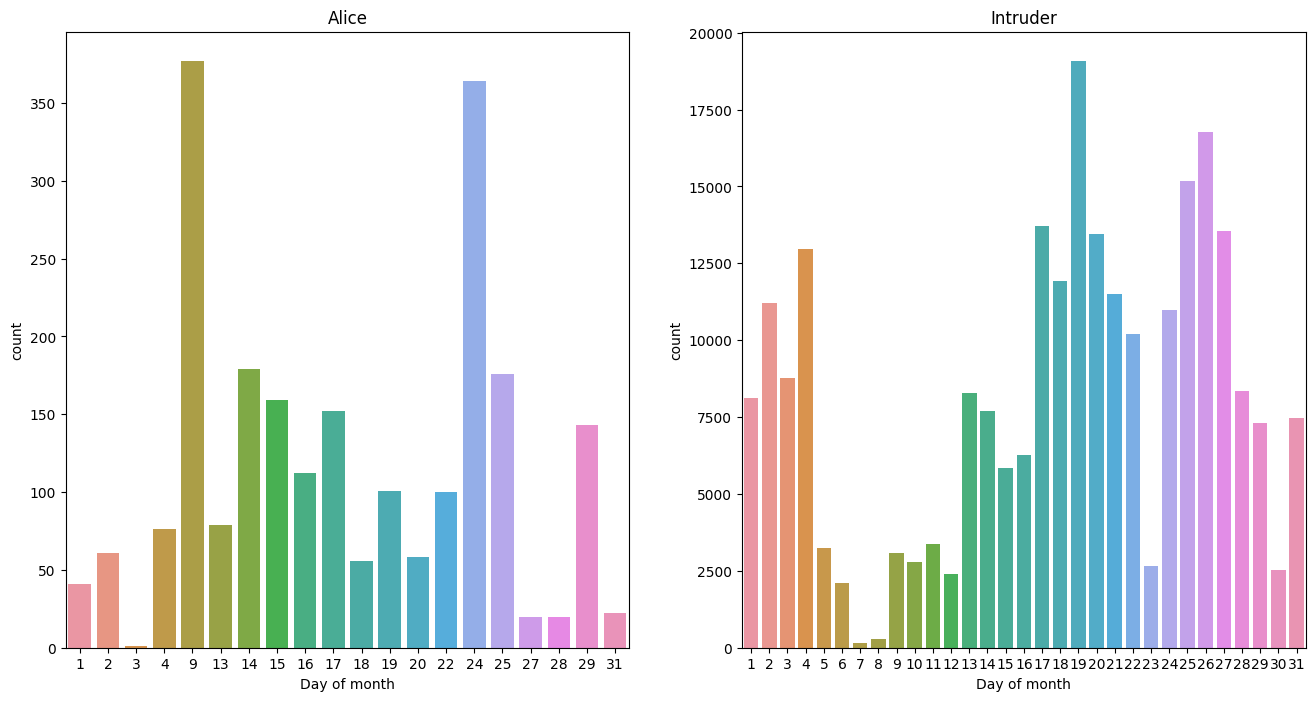

In [24]:
plt.subplots(1, 2, figsize = (16, 8)) 

plt.subplot(1, 2, 1)
sns.countplot(pd.DataFrame(dom[(y_train == 1) ]), x='time1')
plt.title("Alice")
plt.xlabel('Day of month')
          
plt.subplot(1, 2, 2)
sns.countplot(pd.DataFrame(dom[(y_train == 0) ]), x='time1')
plt.title('Intruder')
plt.xlabel('Day of month');

In [25]:
def add_dom(times, X_sparse, add_feat = True):
    
    dom = times['time1'].apply(lambda ts: ts.day)
    dom_1 = (dom.isin([3,5,6,7,8,10,11,12,21,23,27,28,30])).values.reshape(-1, 1)
    dom_2 = (dom.isin([9,24])).values.reshape(-1, 1)
    dom_3 = (dom.isin([17,18,19,20,21,22,24,25,26,31])).values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse,  dom_1, dom_2, dom_3]
    feature_names = ['dom_1', 'dom_2', 'dom_3']   
    
    if add_feat:
        corr_df.append(pd.DataFrame(dom_1, columns = ['dom_1']))
        corr_df.append(pd.DataFrame(dom_2, columns = ['dom_2']))
        corr_df.append(pd.DataFrame(dom_3, columns = ['dom_3']))
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [26]:
X_train_final, dom_features = add_dom(train_times, X_train_final)
X_test_final, _ = add_dom(test_times, X_test_final, add_feat = False)
features_name += dom_features

# Final training

This is it! All we have to do is train the model and look at the result.

In [121]:
final_model = LogisticRegression(C=20, random_state=SEED, solver='liblinear')

In [125]:
proba, ideal, predicted, table_confusion, cv_scores = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=features_name,
                               cv=time_split, submission_file_name='/kaggle/working/submission_alice_baseLR_3.csv')

CV scores [0.83249942 0.97527648 0.97879187 0.87632393 0.96045391 0.9376713
 0.89678833 0.96490126 0.98910681 0.98376999]
CV mean: 0.9395583306970406, CV std: 0.05059318267313494


Weight?,Feature
+18.730,cid-ed6c3e6a5c6608a4.users.storage.live.com
+11.358,www.banque-chalus.fr
+11.342,video.tt
+10.237,t.voyages-sncf.com
+10.216,static.weezbe.com
+10.159,www.video.tt
+9.911,www.qapa.fr
+9.319,zupimages.net
+9.108,www.kickstarter.com
+9.095,www.tete-en-lair.com


New feature weights:
                feature      coef
0             morning_1 -4.298749
1             morning_2 -1.567907
2                 day_1 -0.735651
3                 day_2 -0.232516
4                 day_3 -1.167894
5                 day_4 -2.820913
6                 day_5 -4.444067
7             evening_1  0.338913
8             evening_2 -0.607070
9             evening_3  0.627045
10                night -8.623180
11    weekday_weekday_0  0.909272
12    weekday_weekday_1  0.674942
13    weekday_weekday_4  0.016722
14  weekday_weekday_5_6 -5.687312
15  weekday_weekday_2_3 -1.784857
16                dom_1 -3.209313
17                dom_2  1.042745
18                dom_3 -0.980715
[[251193     71]
 [   451   1846]]


The model gives a result of 0.96878 on the public board. We got into the top 50 of leaderboard using just Logistic Regression, TF-IDF and three time features! 

In [96]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_train.tolist(), predicted.tolist())

array([[251193,     71],
       [   451,   1846]])

In [132]:
def std(x):
    return (x - np.mean(x)) / np.std(x)



In [136]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, std(proba[:,1]))

0.9980711194206444

In [ ]:
predicted = np.load('/kaggle/working/test_pred_LR.npy')
predicted = np.where(predicted > 0.5, 1, 0)
confusion_matrix(y_train, predicted)

# Ensemble Blending CSV

# Feature Selection

In [28]:
# !pip3 install -U lightautoml
import pickle

In [29]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
#     display_html(eli5.show_weights(estimator=model, 
#                   feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
        
    proba = model.predict_proba(X_train)
    predicted = model.predict(X_train)
#     table_confusion = confusion_matrix(y_train, predicted)
#     test_pred = model.predict_proba(X_test)[:, 1]
#     write_to_submission_file(test_pred, submission_file_name) 
    
    all_feat_imp = model.coef_.flatten()[:]
    
    return (proba, y_train, predicted, cv_scores, all_feat_imp)

In [30]:
final_model = LogisticRegression(C=20, random_state=SEED, solver='liblinear')

In [31]:
proba, ideal, predicted, cv_scores, all_feat_imp = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=features_name,
                               cv=time_split, submission_file_name='submission.csv')

CV scores [0.83249942 0.97527648 0.97879187 0.87632393 0.96045391 0.9376713
 0.89678833 0.96490126 0.98910681 0.98376999]
CV mean: 0.9395583306970406, CV std: 0.05059318267313494
New feature weights:
                feature      coef
0             morning_1 -4.298749
1             morning_2 -1.567907
2                 day_1 -0.735651
3                 day_2 -0.232516
4                 day_3 -1.167894
5                 day_4 -2.820913
6                 day_5 -4.444067
7             evening_1  0.338913
8             evening_2 -0.607070
9             evening_3  0.627045
10                night -8.623180
11    weekday_weekday_0  0.909272
12    weekday_weekday_1  0.674942
13    weekday_weekday_4  0.016722
14  weekday_weekday_5_6 -5.687312
15  weekday_weekday_2_3 -1.784857
16                dom_1 -3.209313
17                dom_2  1.042745
18                dom_3 -0.980715


In [32]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique,counts))

{0: 251264, 1: 2297}

In [33]:
top_10000 = np.argsort(all_feat_imp)[-10000:]

In [31]:
train_csv = pd.read_csv('/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv')

In [36]:
df_test = pd.DataFrame.sparse.from_spmatrix(X_test_final)

In [37]:
df_train = pd.DataFrame.sparse.from_spmatrix(X_train_final)

In [38]:
df_train['target'] = y_train

In [47]:
df_train_top = df_train[df_train.columns[top_10000]]
df_test_top = df_test[df_test.columns[top_10000]]

In [49]:
df_train_top.head()

,23231,10560,21159,5709,23323,12736,27720,19388,14809,11382,...,28961,26967,29995,28376,29242,19842,20162,21477,22493,4610
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
df_train_top.to_pickle('/kaggle/working/train_top_10000.pkl')
df_test_top.to_pickle('/kaggle/working/test_top_10000.pkl')

# df_train.to_pickle('/kaggle/working/train.pkl')
# df_test.to_pickle('/kaggle/working/test.pkl')

# with open('/kaggle/working/all_feat_imp.npy','wb') as f:
#     np.save(f,all_feat_imp)

# AutoML

In [1]:
%%capture
!pip install -U lightautoml

# !pip3 install -U pandas

In [2]:
import pandas as pd

In [3]:
print(pd.__version__)

1.5.3


In [4]:
# Standard python libraries
import os
import time
import pickle

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.validation.np_iterators import TimeSeriesIterator

# Import libraries for XGBoost
# from lightautoml.ml_algo.tuning import RandomTuner
# from lightautoml.ml_algo.boost_l2 import BoostL2MLAlgo

# For NN training
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.layers import Dense, Input, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import BinaryCrossentropy
# from sklearn.preprocessing import StandardScaler

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Previous State DB

In [ ]:
# import dill
# dill.load_session('/kaggle/working/state.db')

## Training

In [15]:
N_THREADS = 10
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 10 * 3600
TARGET_NAME = 'target'

In [21]:
del N_FOLDS

In [7]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [7]:
# 10000 best features
# import pickle
# with open('../input/extractfeats/important_features_10000', 'rb') as f:
#     imp_feats = pickle.load(f)

In [8]:
################ Train on all features ########################
train_data = pd.read_pickle("/kaggle/input/alice-data-sparse/alice-data/train.pkl")
test_data = pd.read_pickle("/kaggle/input/alice-data-sparse/alice-data/test.pkl")
train_data['target'] = train_data['target'].astype('int8')
train_data.columns = train_data.columns.astype(str)
test_data.columns = test_data.columns.astype(str)

In [11]:
######### Train on top 10000 features ##########################
df = pd.read_pickle('/kaggle/input/alice-data-sparse/alice-data/train.pkl')
train_data = pd.read_pickle("/kaggle/input/alice-data-sparse/train_top_10000.pkl")
test_data = pd.read_pickle("/kaggle/input/alice-data-sparse/test_top_10000.pkl")
train_data['target'] = df['target'].astype('int8')
# train_data = train_data.drop('target', 1)
# train_data = train_data.iloc[:,imp_feats]
# test_data = test_data.iloc[:,imp_feats]
# train_data = train_data.join(reserved)
train_data.columns = train_data.columns.astype(str)
test_data.columns = test_data.columns.astype(str)

In [9]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,30010,30011,30012,30013,30014,30015,30016,30017,30018,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.739,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.744,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.752,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.752,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.757,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:
task = Task('binary', metric = 'auc')

In [11]:
roles = {
    'target': 'target',
    'drop': [], 
}

In [16]:
# 'cv': N_FOLDS
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    general_params = {'use_algos': [['linear_l2','lgb','lgb_tuned', 'xgb']]},
    #nested_cv_params = {'cv': 5,  'n_folds': 2},
    #selection_params = {'mode': 2, 'feature_group_size': 50, 'select_algos': ['linear_l2', 'gbm']},
    tuning_params = {'max_tuning_time': 20 * 60},
    lgb_params = {'default_params': {'num_trees': 2000, 'learning_rate': 0.005, 'early_stopping_rounds': 500},'freeze_defaults': True},
                  
)

In [ ]:
%%time 

oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 2)

[03:55:23] Stdout logging level is INFO2.
[03:55:23] Task: binary

[03:55:23] Start automl preset with listed constraints:
[03:55:23] - time: 36000.00 seconds
[03:55:23] - CPU: 10 cores
[03:55:23] - memory: 16 GB

[03:55:23] Train data shape: (253561, 30020)

[04:02:13] Layer 1 train process start. Time left 35590.65 secs
[04:06:08] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[04:06:10] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[04:06:59] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[04:07:44] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[04:08:31] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[04:09:18] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[04:10:01] ===== Start working with fold 5 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[04:10:47] ===== Start working with fold 6 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[04:11:34] ===== Start working with fold 7 for Lvl_0

In [ ]:
print(f'TRAIN out-of-fold score: {roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')

In [ ]:
import joblib

joblib.dump(automl, '/kaggle/working/model2.pkl')
# automl = joblib.load('/kaggle/working/model.pkl')

In [ ]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

with open('/kaggle/working/test_pred_LR_LGBM.npy', 'wb') as f:
    np.save(f,test_pred.data[:, 0])

In [57]:
test_pred.shape[0]

82797

In [58]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
    
#     test_pred = model.predict_proba(X_test)[:, 1]
#     write_to_submission_file(test_pred, submission_file_name) 

# test_pred = automl.predict(test_data)
predicted_labels = test_pred.data[:, 0]
write_to_submission_file(predicted_labels, '/kaggle/working/submission_alice_automl_LGB.csv')
# print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')
# submission = test_pred.data[:, 0]
# np.savetxt("submit.csv", submission, delimiter=",")